In [1]:
# Import all the needful packages-----------------------
import numpy as np
import pandas as pd
import pandas_profiling


import seaborn as sns            # Provides a high level interface for drawing attractive and informative statistical graphics
%matplotlib inline
sns.set()
from subprocess import check_output
# ------------------------------------------------------

In [2]:
# Read the CSV file using 
carsales_df = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Projects/car_sales.csv", encoding='cp1252')

In [3]:
carsales_df.shape

(9576, 10)

In [4]:
carsales_df.info() # Details about Dataframe index, Column Name, Non-null Count, and Datatype of the column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           9576 non-null   object 
 1   price         9576 non-null   float64
 2   body          9576 non-null   object 
 3   mileage       9576 non-null   int64  
 4   engV          9142 non-null   float64
 5   engType       9576 non-null   object 
 6   registration  9576 non-null   object 
 7   year          9576 non-null   int64  
 8   model         9576 non-null   object 
 9   drive         9065 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 748.2+ KB


In [5]:
carsales_df.describe() # Describes the Data of the DataSet. Statistics of DatSet, Min, Max, Inter Quartile Ranges for all quantitative variables

,price,mileage,engV,year
count,9576.000000,9576.000000,9142.000000,9576.000000
mean,15633.317316,138.862364,2.646344,2006.605994
std,24106.523436,98.629754,5.927699,7.067924
min,0.000000,0.000000,0.100000,1953.000000
25%,4999.000000,70.000000,1.600000,2004.000000
50%,9200.000000,128.000000,2.000000,2008.000000
75%,16700.000000,194.000000,2.500000,2012.000000
max,547800.000000,999.000000,99.990000,2016.000000


From this Describe function gives us basic statistics computed on the dataset
* Among the 4 numerical columns, engine has less values in count (all are 9756 except engV). There could be some missing data which should be cleansed.
* *Price* & *Mileage* is having min value as '0', which looks incorrect or outlier. Could be potential candidate for correction/discard the data

In [6]:
carsales_df.isnull().sum()

car               0
price             0
body              0
mileage           0
engV            434
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64

* We can observe engV and drive is missing/null values. 
* These missing or null values we cant replace with any default value

In [7]:
carsales_Profile = pandas_profiling.ProfileReport(carsales_df)
carsales_Profile.to_file("CarSales_Before_Processing.html")

## The profiing report describes
* There are 113 duplicated rows (Action - Remove the duplcates)
* 1% of missing cells are in the dataset (Action - Replace with default/mean value or discard the record)
* 5 Categorical variables, 4 numeric variables and 1 boolean value

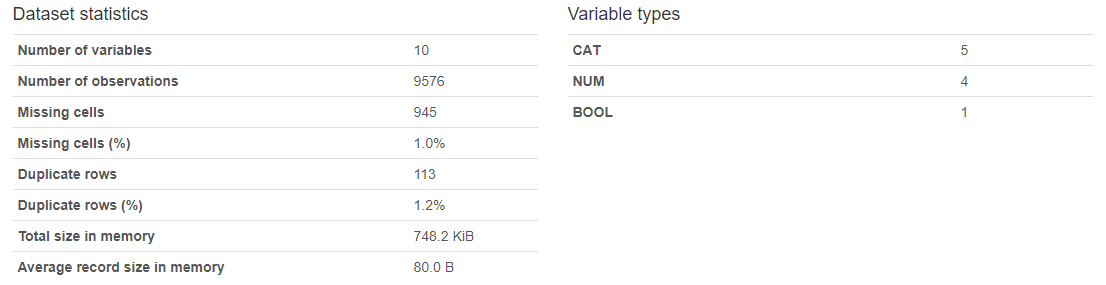


# <div style="text-align:center;background: -webkit-linear-gradient(#fff, #888);-webkit-background-clip: text;-webkit-text-fill-color: transparent;"> Data Processing </div>


In [8]:
carsales_df.isnull().sum()

car               0
price             0
body              0
mileage           0
engV            434
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64

In [9]:
# lets Drop the duplicate Value

carsales_df.drop_duplicates(inplace=True)
carsales_df.shape

(9463, 10)

<AxesSubplot:ylabel='Frequency'>

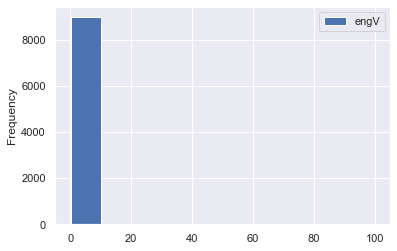

In [12]:
pd.DataFrame(carsales_df['engV']).plot.hist()

<AxesSubplot:>

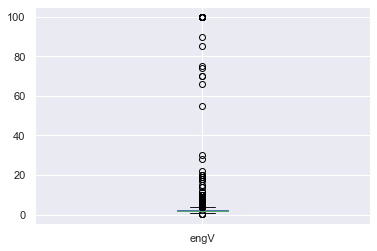

In [13]:
pd.DataFrame(carsales_df['engV']).plot.box()

In [14]:
pd.DataFrame(carsales_df['engV']).describe()

,engV
count,9029.000000
mean,2.641444
std,5.963016
min,0.100000
25%,1.600000
50%,2.000000
75%,2.500000
max,99.990000


# Fixing *engV* missing / erroneous values

In [15]:
'''
Function that removes the ourlier entries of engV and returns dataframe
'''
def exclude_outliers_for_engV():
    return pd.DataFrame(carsales_df[(carsales_df.engV > 0.5) & (carsales_df.engV < 25)])



'''
Function that computes the mean value of engV based on make and model 
'''
def compute_engV_mean(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return round(r.mean(),2)
    else:
        engV_df = exclude_outliers_for_engV()
        engV_make = engV_df[engV_df.car == car_make].engV
        if engV_make.count() > 0:
            return round(engV_make.mean(),2)
        else:
            return round(engV_df.engV.mean(),2)
        
'''
Create a staging "engV mean" dataframe for  all combinations of make and model
'''
engV_mean = carsales_df.groupby(['car','model']).engV.apply(compute_engV_mean).reset_index()
engV_mean.rename(columns={'engV':'engV_avg'}, inplace=True)
engV_mean.head(10)

,car,model,engV_avg
0,Acura,MDX,3.62
1,Acura,RL,3.50
2,Acura,TL,3.20
3,Acura,TLX,2.40
4,Acura,ZDX,3.70
5,Alfa Romeo,147,1.60
6,Alfa Romeo,156,1.85
7,Alfa Romeo,159,2.20
8,Alfa Romeo,33,1.70
9,Alfa Romeo,75,1.60


In [16]:
'''
Function that return engV value for missing records
'''
def get_missing_engV(r):
    if pd.isnull(r.engV):
        return engV_mean[(engV_mean.car == r.car) & (engV_mean.model == r.model)].engV_avg.values[0]
    else:
        return r.engV
    

'''
Fix the missing engV values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.engV.isnull()].shape)

carsales_df.engV = carsales_df.apply(get_missing_engV, axis=1)


print('--------------After fix -----------------')
print(carsales_df[carsales_df.engV.isnull()].shape)

--------------Before fix-----------------
(434, 10)
--------------After fix -----------------
(0, 10)


# Fixing *price* missing / erroneous values

In [17]:
'''
Function that computes the median value of price based on make and model 
'''
def compute_price_median(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if (r.count() > 0) & (r.median() > 0):
        return r.median()
    else:
        price_make = carsales_df[carsales_df.car == car_make].price
        if price_make.median() > 0:
            return price_make.median()
        else:
            return carsales_df.price.median()

        
'''
Create a staging "Price median" dataframe for  all combinations of make and model
'''
price_median = carsales_df.groupby(['car','model']).price.apply(compute_price_median).reset_index()
price_median.rename(columns={'price':'price_median'}, inplace=True)
price_median.head(10)

,car,model,price_median
0,Acura,MDX,17200.0
1,Acura,RL,13950.0
2,Acura,TL,8699.0
3,Acura,TLX,38200.0
4,Acura,ZDX,30999.0
5,Alfa Romeo,147,5900.0
6,Alfa Romeo,156,2325.0
7,Alfa Romeo,159,12050.0
8,Alfa Romeo,33,1800.0
9,Alfa Romeo,75,2300.0


In [18]:
'''
Function that return price value for missing records
'''
def get_missing_price(r):
    if r.price == 0:
        return price_median[(price_median.car == r.car) & (price_median.model == r.model)].price_median.values[0]
    else:
        return r.price
    

'''
Fix the missing price values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.price == 0].shape)

carsales_df.price = carsales_df.apply(get_missing_price, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.price == 0].shape)

--------------Before fix-----------------
(240, 10)
--------------After fix -----------------
(0, 10)


# Fixing *mileage* missing / erroneous values

In [19]:
'''
Function that computes the median value of mileage based on make and model 
'''
def compute_mileage_median(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if (r.count() > 0) & (r.median() > 0):
        return r.median()
    else:
        mileage_make = carsales_df[carsales_df.car == car_make].mileage
        if mileage_make.median() > 0:
            return mileage_make.median()
        else:
            return carsales_df.mileage.median()
        

        '''
Create a staging "mileage median" dataframe for  all combinations of make and model
'''
mileage_median = carsales_df.groupby(['car','model']).mileage.apply(compute_mileage_median).reset_index()
mileage_median.rename(columns={'mileage':'mileage_median'}, inplace=True)
mileage_median.head(10)

,car,model,mileage_median
0,Acura,MDX,85.0
1,Acura,RL,138.0
2,Acura,TL,145.0
3,Acura,TLX,4.0
4,Acura,ZDX,32.0
5,Alfa Romeo,147,199.0
6,Alfa Romeo,156,162.0
7,Alfa Romeo,159,120.5
8,Alfa Romeo,33,185.0
9,Alfa Romeo,75,122.0


In [20]:
'''
Function that return mileage value for missing records
'''
def get_missing_mileage(r):
    if r.mileage == 0:
        return mileage_median[(mileage_median.car == r.car) & (mileage_median.model == r.model)].mileage_median.values[0]
    else:
        return r.mileage
    

'''
Fix the missing price values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.mileage == 0].shape)

carsales_df.mileage = carsales_df.apply(get_missing_mileage, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.mileage == 0].shape)

--------------Before fix-----------------
(310, 10)
--------------After fix -----------------
(0, 10)


# Fixing *drive* missing / erroneous values

In [21]:
'''
Function that removes the null entries of drive and returns dataframe
'''
def get_clensed_data_for_drive():
    return pd.DataFrame(carsales_df[carsales_df.drive.isnull() == False])


'''
Function that computes the mode value of drive based on make and model 
'''
def compute_drive(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return r.mode()
    else:
        drive_df = get_clensed_data_for_drive()
        drive_make = drive_df[drive_df.car == car_make].drive
        if drive_make.count() > 0:
            return drive_make.mode()
        else:
            return drive_df.drive.mode()
        
        
'''
Create a staging "drive mode" dataframe for  all combinations of make and model
'''
drive_mode = carsales_df.groupby(['car','model']).drive.apply(compute_drive).reset_index()
drive_mode.rename(columns={'drive':'drive_mode'}, inplace=True)
drive_mode.drop('level_2', axis=1)

,car,model,drive_mode
0,Acura,MDX,full
1,Acura,RL,full
2,Acura,TL,front
3,Acura,TLX,front
4,Acura,ZDX,full
...,...,...,...
914,ZX,LandMark,full
915,ËUAZ,1301,full
916,ËUAZ,1302,full
917,ËUAZ,969 Âîëûíü,full


In [22]:
'''
Function that return drive value for missing records
'''
def get_missing_drive(r):
    if pd.isnull(r.drive):
        return drive_mode[(drive_mode.car == r.car) & (drive_mode.model == r.model)].drive_mode.values[0]
    else:
        return r.drive
    
'''
Fix the missing drive values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

carsales_df.drive = carsales_df.apply(get_missing_drive, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

--------------Before fix-----------------
(510, 10)
--------------After fix -----------------
(0, 10)


# Fixing *engType* missing / erroneous values

In [23]:
'''
Function that removes the null entries of engType and returns dataframe
'''
def get_clensed_data_for_engType():
    return pd.DataFrame(carsales_df[carsales_df.engType.isnull() == False])


'''
Function that computes the mode value of drive based on make and model 
'''
def compute_engType(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return r.mode()
    else:
        engType_df = get_clensed_data_for_engType()
        engType_make = engType_df[engType_df.car == car_make].engType
        if engType_make.count() > 0:
            return engType_make.mode()
        else:
            return engType_df.engType.mode()
        
        
'''
Create a staging "engType mode" dataframe for  all combinations of make and model
'''
engType_mode = carsales_df.groupby(['car','model']).engType.apply(compute_engType).reset_index()
engType_mode.rename(columns={'engType':'engType_mode'}, inplace=True)
engType_mode.drop('level_2', axis=1)

,car,model,engType_mode
0,Acura,MDX,Petrol
1,Acura,RL,Gas
2,Acura,TL,Gas
3,Acura,TLX,Petrol
4,Acura,ZDX,Other
...,...,...,...
984,ZX,LandMark,Petrol
985,ËUAZ,1301,Petrol
986,ËUAZ,1302,Gas
987,ËUAZ,969 Âîëûíü,Petrol


In [24]:
'''
Function that return drive value for missing records
'''
def get_missing_engType(r):
    if pd.isnull(r.engType):
        return engType_mode[(engType_mode.car == r.car) & (engType_mode.model == r.model)].engType_mode.values[0]
    else:
        return r.engType
    
'''
Fix the missing engType values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.engType.isnull()].shape)

carsales_df.engType = carsales_df.apply(get_missing_engType, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.engType.isnull()].shape)

--------------Before fix-----------------
(0, 10)
--------------After fix -----------------
(0, 10)


In [22]:
print(carsales_df[carsales_df.engType.isnull()].shape)

(0, 10)


In [25]:
carsales_Profile = pandas_profiling.ProfileReport(carsales_df)
carsales_Profile.to_file("CarSales_Post_Processing.html")

# <div style="text-align:center;background: -webkit-linear-gradient(#fff, #888);-webkit-background-clip: text;-webkit-text-fill-color: transparent;"> EDA </div>

In [25]:
import matplotlib.pyplot as plt

In [26]:
top_ten_carsales = pd.DataFrame(carsales_df.car.value_counts()[0:10]).reset_index()
top_ten_carsales.rename(columns={ 'index':'car', 'car':'sales'}, inplace=True)
top_ten_carsales

,car,sales
0,Volkswagen,927
1,Mercedes-Benz,885
2,BMW,684
3,Toyota,529
4,VAZ,488
5,Renault,467
6,Audi,456
7,Opel,399
8,Skoda,368
9,Nissan,364


In [27]:
rest_of_other_carsales = pd.DataFrame(carsales_df.car.value_counts()[10:]).reset_index()
rest_of_other_carsales.rename(columns={ 'index':'car', 'car':'sales'}, inplace=True)
rest_of_other_carsales

,car,sales
0,Hyundai,362
1,Ford,345
2,Mitsubishi,326
3,Chevrolet,245
4,Daewoo,234
...,...,...
72,Lamborghini,1
73,ZX,1
74,Huanghai,1
75,Saab,1


In [28]:
rest_of_other_carsales_df = pd.DataFrame(data = {
    'car' : ['Others'],
    'sales': rest_of_other_carsales.sales.sum()
})
rest_of_other_carsales_df

,car,sales
0,Others,3896


In [29]:
car_sales = pd.concat([top_ten_carsales, rest_of_other_carsales_df])


<AxesSubplot:>

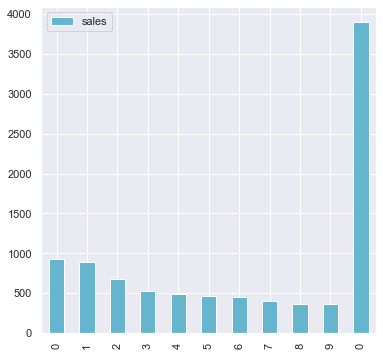

In [30]:
car_sales.plot.bar(color='c',figsize=(6, 6))

In [31]:
car_sales.set_index("car", inplace=True)

In [32]:

#d.plot(kind='bar', ax=f.gca())
car_sales.plot.pie(y="sales", labels = car_sales.car, title='Sales per each Car manufacturer', figsize=(16, 6), autopct='%1.1f%%')


AttributeError: 'DataFrame' object has no attribute 'car'

In [38]:
#car_sales.reset_index()
car_sales.head(2)

,sales
car,
Volkswagen,927
Mercedes-Benz,885


In [34]:
my_explode = (0, 0.1, 0)
plt.pie(car_sales.sales,  labels=car_sales.car, autopct='%1.1f%%')
plt.title('Sales per Car Manufacturer')
plt.axis('equal')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'car'

<AxesSubplot:ylabel='sales'>

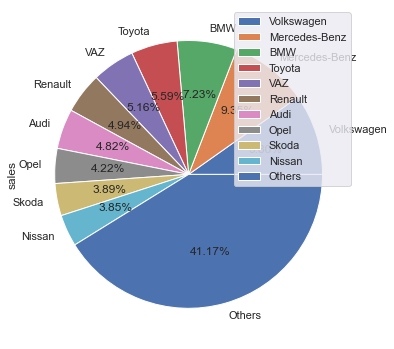

In [39]:
car_sales.plot.pie(y="sales", figsize=(6, 10), autopct='%1.2f%%')

Text(0.5, 1.0, 'Top 10 car brands on sale')

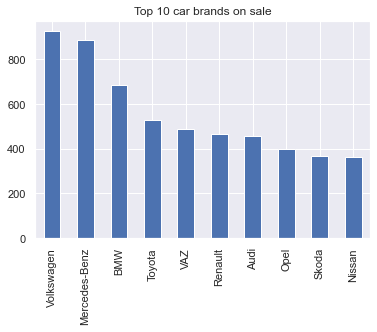

In [40]:
carsales_df.car.value_counts().head(10).plot.bar()
plt.title("Top 10 car brands on sale")

<AxesSubplot:>

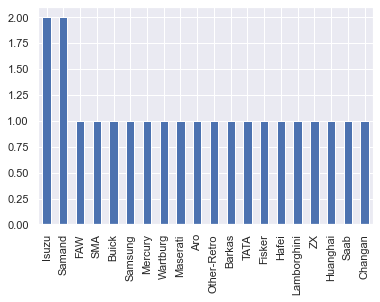

In [41]:
carsales_df.car.value_counts().tail(20).plot.bar()

Text(0.5, 1.0, 'Top 10 car brands on sale')

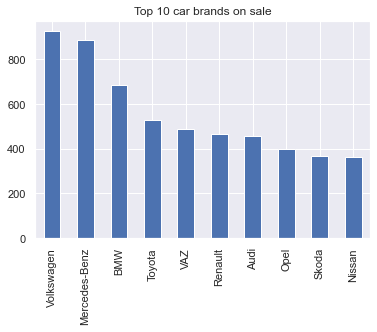

In [42]:
carsales_df.car.value_counts().head(10).plot.bar()
plt.title("Top 10 car brands on sale")

In [43]:
carsales_df.price.nlargest()

7621    547800.0
1611    499999.0
2637    449999.0
4134    449999.0
4325    300000.0
Name: price, dtype: float64

In [44]:
carsales_df[carsales_df.price.isin(carsales_df.price.nlargest())].sort_values('price', ascending=False)

,car,price,body,mileage,engV,engType,registration,year,model,drive
7621,Bentley,547800.0,sedan,20.0,6.75,Petrol,yes,2016,Mulsanne,rear
1611,Bentley,499999.0,crossover,20.0,6.00,Petrol,yes,2016,Bentayga,full
2637,Bentley,449999.0,crossover,1.0,6.00,Petrol,yes,2016,Bentayga,full
4134,Bentley,449999.0,crossover,20.0,6.00,Petrol,yes,2016,Bentayga,full
4325,Mercedes-Benz,300000.0,sedan,68.0,6.00,Petrol,yes,2011,S 600,rear
5849,Mercedes-Benz,300000.0,other,37.0,5.00,Petrol,yes,2012,G 500,full


In [45]:
carsales_maxprice = pd.DataFrame(carsales_df.groupby('car').price.max()).reset_index()            #.sort_values('price').head().plot.barh()

In [46]:
carsales_maxprice

,car,price
0,Acura,46999.000
1,Alfa Romeo,17500.000
2,Aro,3600.000
3,Aston Martin,125000.000
4,Audi,98000.000
...,...,...
82,Volvo,66795.000
83,Wartburg,1000.000
84,ZAZ,8584.485
85,ZX,7700.000


In [65]:
carsales_maxprice.rename(columns={'price':'max_price'}, inplace=True)

<AxesSubplot:>

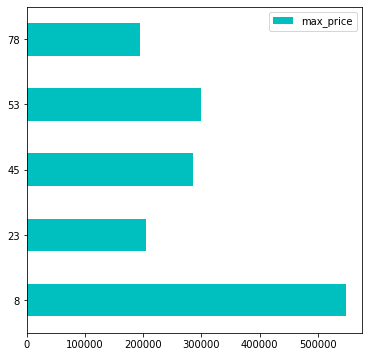

In [91]:
carsales_maxprice[carsales_maxprice.max_price.isin(carsales_maxprice.max_price.nlargest())].plot.barh(color='c',figsize=(6, 6))

In [76]:
carsales_maxprice.max_price.nlargest()

8     547800.0
53    300000.0
45    285000.0
23    205000.0
78    195000.0
Name: max_price, dtype: float64

D:\ProgramData\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  after removing the cwd from sys.path.


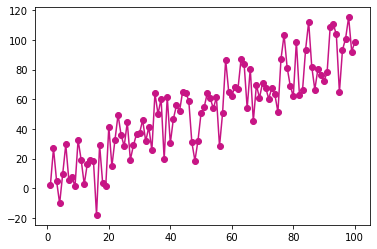

In [83]:
df=pd.DataFrame({'x': range(1,101), 'y': np.random.randn(100)*15+range(1,101), 'z': (np.random.randn(100)*15+range(1,101))*2 })

# plot
plt.plot( 'x', 'y', data=df, marker='o', color='mediumvioletred')

In [95]:
toppricedcars = carsales_maxprice[carsales_maxprice.max_price.isin(carsales_maxprice.max_price.nlargest())]#.plot.barh()

<AxesSubplot:ylabel='car'>

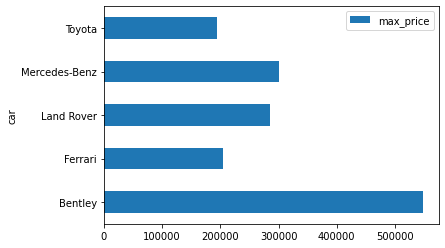

In [100]:
toppricedcars.plot.barh(x="car", y='max_price')

<AxesSubplot:ylabel='car'>

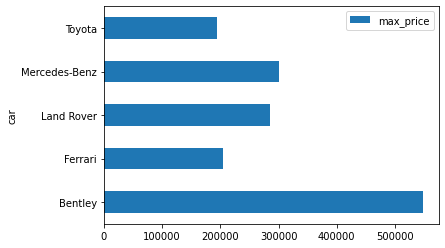

In [101]:
carsales_maxprice[carsales_maxprice.max_price.isin(carsales_maxprice.max_price.nlargest())].plot.barh(x="car", y='max_price')

<AxesSubplot:ylabel='car'>

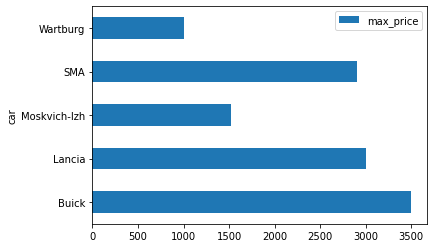

In [105]:
carsales_maxprice[carsales_maxprice.max_price.isin(carsales_maxprice.max_price.nsmallest())].plot.barh(x="car", y='max_price')

,car,max_price
0,Acura,46999.000
1,Alfa Romeo,17500.000
2,Aro,3600.000
3,Aston Martin,125000.000
4,Audi,98000.000
...,...,...
82,Volvo,66795.000
83,Wartburg,1000.000
84,ZAZ,8584.485
85,ZX,7700.000


<AxesSubplot:>

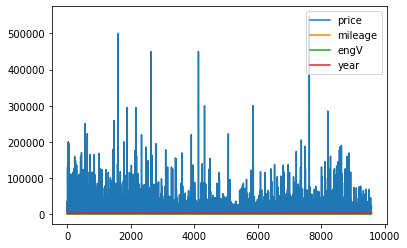

In [82]:
carsales_df.plot.line()

In [88]:
carsales_df.car.value_counts().head(20)

Volkswagen       927
Mercedes-Benz    885
BMW              684
Toyota           529
VAZ              488
Renault          467
Audi             456
Opel             399
Skoda            368
Nissan           364
Hyundai          362
Ford             345
Mitsubishi       326
Chevrolet        245
Daewoo           234
Kia              214
Honda            204
Mazda            198
Peugeot          182
Lexus            171
Name: car, dtype: int64

In [90]:
carsales_df.car.count()

9463

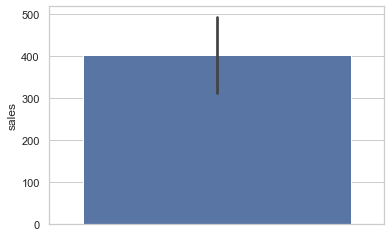

In [110]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(y="sales", data=df1)

In [117]:
df1 = pd.DataFrame(carsales_df.car.value_counts().head(20))

df1

,car
Volkswagen,927
Mercedes-Benz,885
BMW,684
Toyota,529
VAZ,488
Renault,467
Audi,456
Opel,399
Skoda,368
Nissan,364


In [118]:

df1.reset_index()
df1

,car
Volkswagen,927
Mercedes-Benz,885
BMW,684
Toyota,529
VAZ,488
Renault,467
Audi,456
Opel,399
Skoda,368
Nissan,364


In [115]:
df1

,sales
Volkswagen,927
Mercedes-Benz,885
BMW,684
Toyota,529
VAZ,488
Renault,467
Audi,456
Opel,399
Skoda,368
Nissan,364


In [51]:
carsales_df.head()
#print(carsales_df.shape)

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68.0,2.50,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173.0,1.80,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135.0,5.50,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162.0,1.80,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91.0,2.57,Other,yes,2013,E-Class,rear


In [76]:
def categorize_class(r):
    if r.price <= 10000:
        return "Economy"
    elif (r.price > 10000) & (r.price < 30000):
        return "Luxury"
    else:
        return "Super Luxury"

In [77]:
carsales_df['class'] = carsales_df.apply(categorize_class, axis=1)

In [78]:
carsales_df.head()

,car,price,body,mileage,engV,engType,registration,year,model,drive,class
0,Ford,15500.0,crossover,68.0,2.50,Gas,yes,2010,Kuga,full,Luxury
1,Mercedes-Benz,20500.0,sedan,173.0,1.80,Gas,yes,2011,E-Class,rear,Luxury
2,Mercedes-Benz,35000.0,other,135.0,5.50,Petrol,yes,2008,CL 550,rear,Super Luxury
3,Mercedes-Benz,17800.0,van,162.0,1.80,Diesel,yes,2012,B 180,front,Luxury
4,Mercedes-Benz,33000.0,vagon,91.0,2.57,Other,yes,2013,E-Class,rear,Super Luxury


In [82]:
carsales_df['class'].value_counts()

Economy         5019
Luxury          3389
Super Luxury    1055
Name: class, dtype: int64

In [80]:
carsales_df.price.describe()

count      9463.000000
mean      15948.897726
std       23754.171644
min         259.350000
25%        5450.000000
50%        9500.000000
75%       16999.000000
max      547800.000000
Name: price, dtype: float64

In [83]:
carsales_df.groupby('class').year.value_counts()

class         year
Economy       2008    572
              2007    540
              2006    364
              2005    294
              2004    257
                     ... 
Super Luxury  2003      2
              1969      1
              1993      1
              2001      1
              2004      1
Name: year, Length: 101, dtype: int64

In [88]:
carsales_df.to_csv('Carsales.csv')

In [121]:
table = pd.pivot_table(carsales_df,values='model', index=['car','year'], columns=['class'], aggfunc='count')

In [122]:
table

class       Economy  Luxury  Super Luxury
car   year                               
Acura 2005      4.0     1.0           NaN
      2006      NaN     1.0           NaN
      2008      NaN     4.0           NaN
      2010      NaN     NaN           1.0
      2014      NaN     NaN           1.0
...             ...     ...           ...
ËUAZ  1987      1.0     NaN           NaN
      1990      1.0     NaN           NaN
      1991      2.0     NaN           NaN
      1994      1.0     NaN           NaN
      2004      1.0     NaN           NaN

[1016 rows x 3 columns]

In [123]:
table.index

MultiIndex([(     'Acura', 2005),
            (     'Acura', 2006),
            (     'Acura', 2008),
            (     'Acura', 2010),
            (     'Acura', 2014),
            (     'Acura', 2015),
            ('Alfa Romeo', 1991),
            ('Alfa Romeo', 2000),
            ('Alfa Romeo', 2002),
            ('Alfa Romeo', 2003),
            ...
            (       'ZAZ', 2012),
            (       'ZAZ', 2013),
            (       'ZAZ', 2014),
            (       'ZAZ', 2015),
            (        'ZX', 2006),
            (      'ËUAZ', 1987),
            (      'ËUAZ', 1990),
            (      'ËUAZ', 1991),
            (      'ËUAZ', 1994),
            (      'ËUAZ', 2004)],
           names=['car', 'year'], length=1016)

In [115]:
table[np.in1d(table.index.get_level_values(1), [2005])].fillna("")

,class,Economy,Luxury,Super Luxury
car,year,,,
Acura,2005,4,1,
Audi,2005,3,11,
BMW,2005,3,24,
Bentley,2005,,,1
Changan,2005,1,,
Chery,2005,1,,
Chevrolet,2005,23,,
Chrysler,2005,,4,
Citroen,2005,5,,


In [119]:
table_year = pd.pivot_table(carsales_df,values='car', index=['year'], columns=['class'], aggfunc='count')

In [124]:
table_year.replace(np.nan,"")

class,Economy,Luxury,Super Luxury
year,,,
1953,,1,
1958,1,,
1959,1,,
1961,2,,
1962,1,1,
1963,1,1,
1964,1,,
1968,1,,
1969,2,,1


In [125]:
revenue = pd.pivot_table(carsales_df,values='price', index=['car','year'], columns=['class'], aggfunc='sum')

In [126]:
revenue

class        Economy   Luxury  Super Luxury
car   year                                 
Acura 2005  34648.00  11111.0           NaN
      2006       NaN  12900.0           NaN
      2008       NaN  66350.0           NaN
      2010       NaN      NaN       30999.0
      2014       NaN      NaN       46999.0
...              ...      ...           ...
ËUAZ  1987   1500.00      NaN           NaN
      1990   1296.75      NaN           NaN
      1991   2700.00      NaN           NaN
      1994   3500.00      NaN           NaN
      2004   5950.00      NaN           NaN

[1016 rows x 3 columns]

In [130]:
revenue[np.in1d(revenue.index.get_level_values(0), ['Volvo'])].fillna("")

class      Economy Luxury Super Luxury
car   year                            
Volvo 1986    3000                    
      1993    2900                    
      1995    4800                    
      1996    5000                    
      2000   16899                    
      2001    2900                    
      2005          15300             
      2006    7900  21199             
      2008          62799             
      2009          50899             
      2011          65880             
      2012          36500        33500
      2013          43899             
      2014                       34900
      2016                      186495

In [138]:
revenue[np.in1d(revenue.index.get_level_values(1), [1994])].fillna("")

,class,Economy,Luxury,Super Luxury
car,year,,,
Audi,1994,10450.000,,
BMW,1994,40150.000,,
Chevrolet,1994,3500.000,,
Chrysler,1994,3800.000,,
Dodge,1994,3550.000,,
Fiat,1994,1350.000,,
Ford,1994,13649.000,13000,
Honda,1994,3500.000,,
Hyundai,1994,2300.000,,


In [136]:
revenue.

MultiIndex([(     'Acura', 2005),
            (     'Acura', 2006),
            (     'Acura', 2008),
            (     'Acura', 2010),
            (     'Acura', 2014),
            (     'Acura', 2015),
            ('Alfa Romeo', 1991),
            ('Alfa Romeo', 2000),
            ('Alfa Romeo', 2002),
            ('Alfa Romeo', 2003),
            ...
            (       'ZAZ', 2012),
            (       'ZAZ', 2013),
            (       'ZAZ', 2014),
            (       'ZAZ', 2015),
            (        'ZX', 2006),
            (      'ËUAZ', 1987),
            (      'ËUAZ', 1990),
            (      'ËUAZ', 1991),
            (      'ËUAZ', 1994),
            (      'ËUAZ', 2004)],
           names=['car', 'year'], length=1016)

In [141]:
revenue2 = pd.pivot_table(carsales_df,values='price', index=['year','car',], aggfunc='sum')

In [142]:
revenue2

price
year car                        
1953 Moskvich-AZLK  1.100000e+04
1958 GAZ            2.100000e+03
1959 GAZ            2.593500e+02
1961 GAZ            5.000000e+02
     ZAZ            4.000000e+03
...                          ...
2016 Toyota         1.826060e+06
     UAZ            5.500000e+03
     VAZ            2.902794e+04
     Volkswagen     9.447080e+05
     Volvo          1.864950e+05

[1016 rows x 1 columns]

<AxesSubplot:xlabel='year,car'>

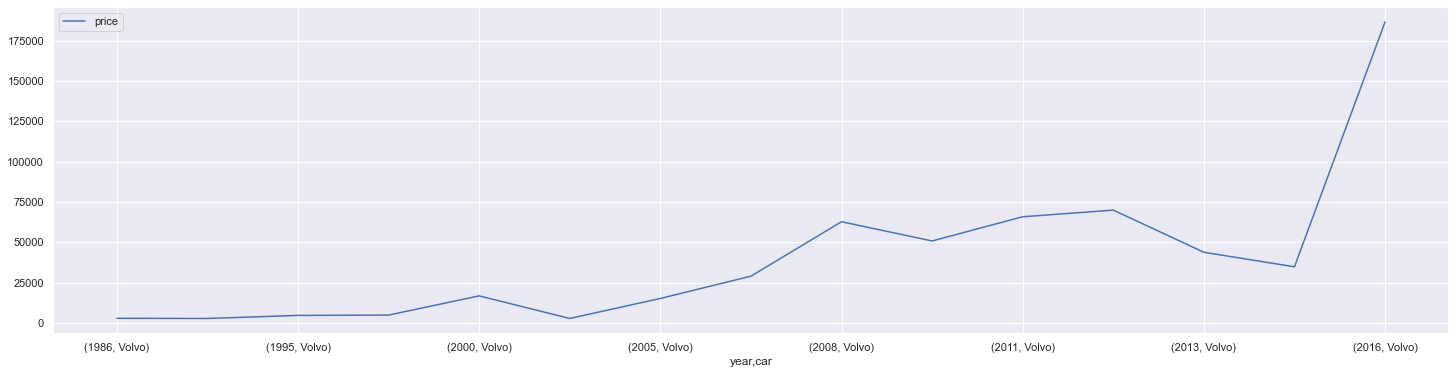

In [149]:
revenue2[np.in1d(revenue2.index.get_level_values(1), ['Volvo'])].plot.line(figsize=(25,6))